# 1. Project Introduction
- Project goal
- Dataset source (Our World in Data)
- What will be analyzed (cases, deaths, vaccination, trends)

# 2. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 3. Load the Dataset

In [2]:
df = pd.read_csv("owid-covid-data.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['location', 'date'])


# 4. Initial Exploration

In [5]:
df.info()
df.describe()
df['location'].nunique() 
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    429435 non-null  object        
 1   continent                                   402910 non-null  object        
 2   location                                    429435 non-null  object        
 3   date                                        429435 non-null  datetime64[ns]
 4   total_cases                                 411804 non-null  float64       
 5   new_cases                                   410159 non-null  float64       
 6   new_cases_smoothed                          408929 non-null  float64       
 7   total_deaths                                411804 non-null  float64       
 8   new_deaths                                  410608 non-null  float64      

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


# 5. Data Cleaning

In [6]:
df = df[~df['location'].isin(['World', 'International'])]
df = df.dropna(subset=['population'])
df['new_cases'] = df['new_cases'].fillna(0)
df['new_deaths'] = df['new_deaths'].fillna(0)


# 6. Select Country for Analysis

In [8]:
country = 'United States'
country_df = df[df['location'] == country].copy()
country_df.sort_values('date', inplace=True)


# 7. Handle Missing Data (Vaccination Forward Fill)

In [23]:
country_df['people_vaccinated'] = country_df['people_vaccinated'].ffill()


# 8. Line Chart – Daily Cases & Deaths

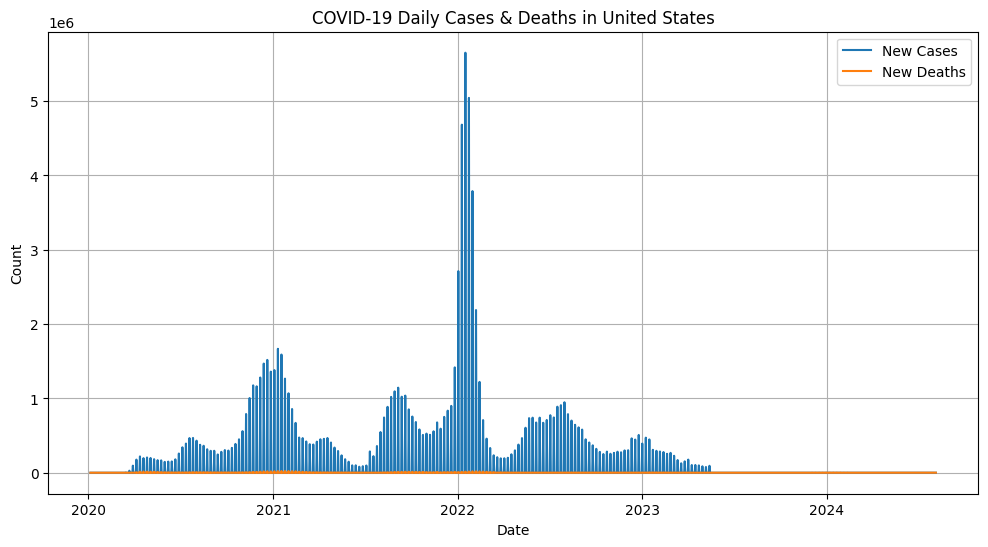

In [24]:
plt.figure(figsize=(12,6))
plt.plot(country_df['date'], country_df['new_cases'], label='New Cases')
plt.plot(country_df['date'], country_df['new_deaths'], label='New Deaths')
plt.title(f"COVID-19 Daily Cases & Deaths in {country}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


# 9. Bar Chart – Monthly Cases per Million

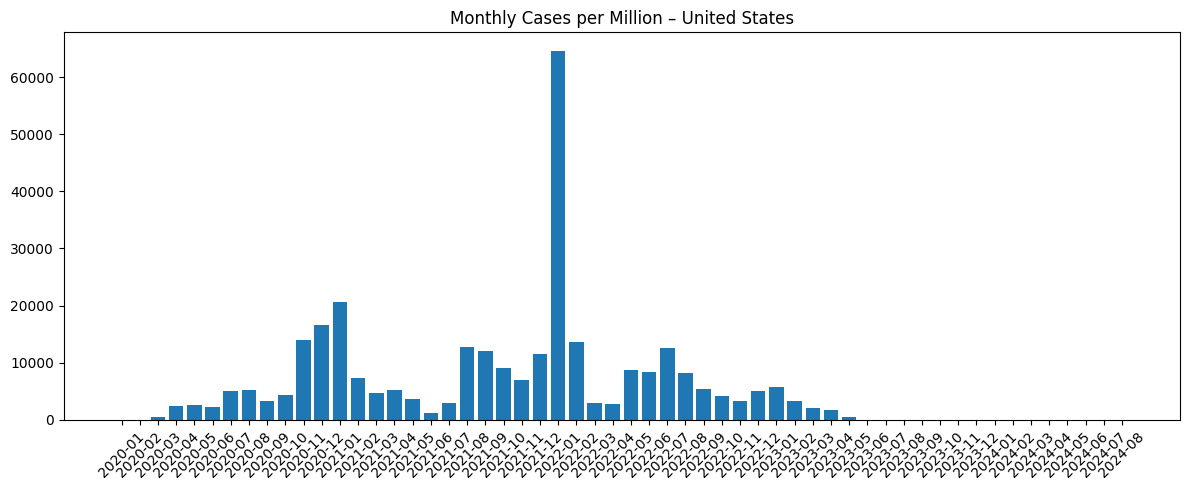

In [25]:
monthly = country_df.copy()
monthly['month'] = monthly['date'].dt.to_period('M')
monthly['new_cases_per_million'] = (monthly['new_cases'] / monthly['population']) * 1e6
monthly_grouped = monthly.groupby('month')['new_cases_per_million'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.bar(monthly_grouped['month'].astype(str), monthly_grouped['new_cases_per_million'])
plt.xticks(rotation=45)
plt.title(f"Monthly Cases per Million – {country}")
plt.tight_layout()
plt.show()


# 10. Pie Chart – Vaccinated vs Unvaccinated

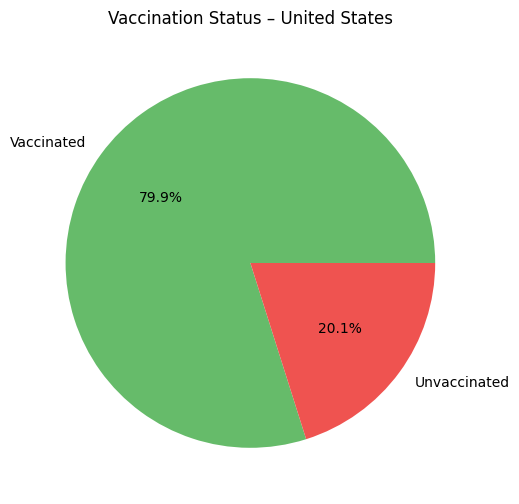

In [26]:
latest = country_df.dropna(subset=['people_vaccinated']).iloc[-1]
vaccinated = latest['people_vaccinated']
population = latest['population']
unvaccinated = population - vaccinated

plt.figure(figsize=(6,6))
plt.pie([vaccinated, unvaccinated],
        labels=['Vaccinated', 'Unvaccinated'],
        autopct='%1.1f%%',
        colors=['#66bb6a', '#ef5350'])
plt.title(f"Vaccination Status – {country}")
plt.show()


# 11.Correlation Heatmap

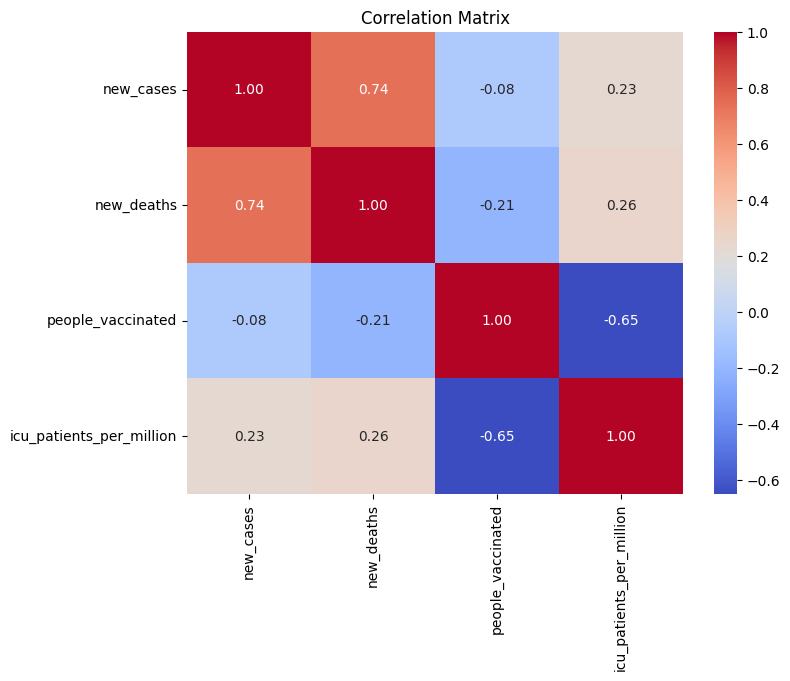

In [27]:
corr_cols = ['new_cases', 'new_deaths', 'people_vaccinated', 'icu_patients_per_million']
heat_df = country_df[corr_cols].dropna()

plt.figure(figsize=(8,6))
sns.heatmap(heat_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


# 12. Multi-Country Comparison

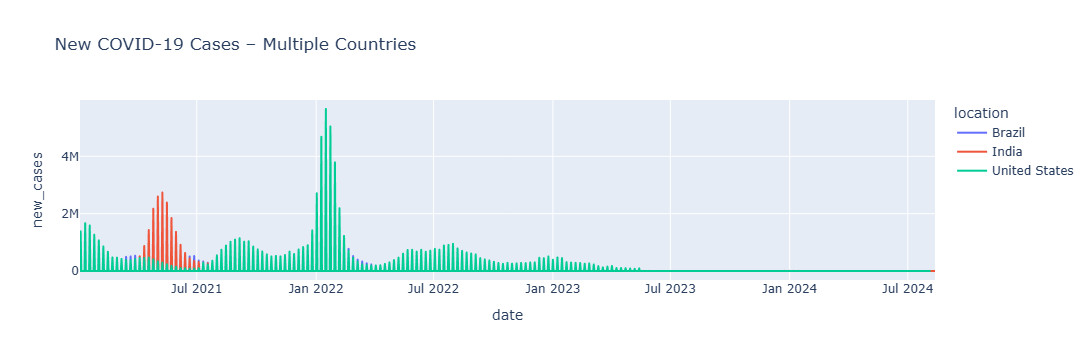

In [28]:
countries = ['United States', 'India', 'Brazil']
multi_df = df[df['location'].isin(countries) & (df['date'] > '2021-01-01')]

fig = px.line(multi_df,
              x='date', y='new_cases',
              color='location',
              title='New COVID-19 Cases – Multiple Countries')
fig.show()


# 13. Highest Cases per Country (Latest Date)

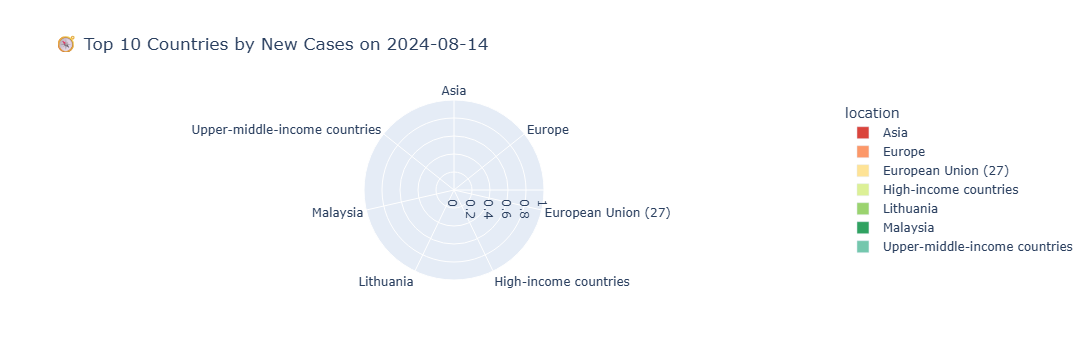

In [29]:
import plotly.express as px

# Get top 10 countries by new cases on the latest date
latest_date = df['date'].max()
latest_df = df[df['date'] == latest_date]
top_cases = latest_df[['location', 'new_cases']].sort_values(by='new_cases', ascending=False).head(10)

# Define custom color palette
custom_colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60',
                 '#1a9850', '#66c2a5', '#3288bd', '#5e4fa2', '#984ea3']

# Polar Bar Chart with custom colors
fig = px.bar_polar(top_cases,
                   r='new_cases',
                   theta='location',
                   color='location',
                   title=f"🧭 Top 10 Countries by New Cases on {latest_date.date()}",
                   color_discrete_sequence=custom_colors)

fig.update_traces(opacity=0.9)
fig.show()


# 14. Summary of Findings

## 🔍 Summary of Insights
- The United States experienced major case spikes in late 2020 and 2021.
- Vaccination rates reached around 70–80% by mid-2022.
- A strong correlation exists between ICU admissions and death rates.
- Brazil and India followed similar but lagged case curves compared to the US.


# Export Cleaned Data

In [30]:
country_df.to_csv(f"{country.lower().replace(' ', '_')}_covid_cleaned.csv", index=False)
